* **Поекспериментуємо з претрейнд моделлю "nvidia/segformer-b5-finetuned-ade-640-640" для Semantic Segmentation зображень.**

* **Візьмемо зображення з розміченого датасету, процесимо його а потім порівняємо з ground truth цього зображення з анотованого датасету.**


## **1. Import Libraries**

In [ ]:
from transformers import AutoImageProcessor, SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from huggingface_hub import hf_hub_download
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **2. Load the Model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"

processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)
model.config    # Check the configuration of the model including its classes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

SegformerConfig {
  "_name_or_path": "nvidia/segformer-b5-finetuned-ade-640-640",
  "architectures": [
    "SegformerForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 768,
  "depths": [
    3,
    6,
    40,
    3
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    64,
    128,
    320,
    512
  ],
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road",
    "7": "bed ",
    "8": "windowpane",
    "9": "grass",
    "10": "cabinet",
    "11": "sidewalk",
    "12": "person",
    "13": "earth",
    "14": "door",
    "15": "table",
    "16": "mountain",
    "17": "plant",
    "18": "curtain",
    "19": "chair",
    "20": "car",
    "21": "water",
    "22": "painting",
    "23": "sofa",
    "24": "shelf",
    "25": "

## **3. Arrange the Image**

ADE_val_00000002.jpg:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

ADE_val_00000002.png:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

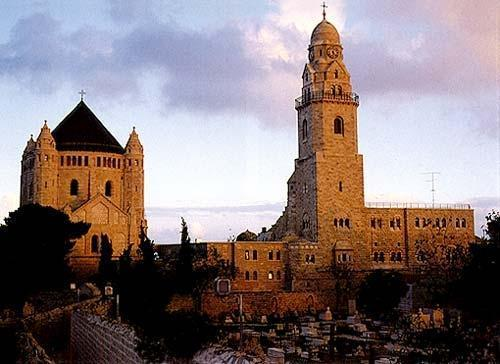

In [ ]:
# Load image + ground truth map
repo_id = "hf-internal-testing/fixtures_ade20k"
image_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000002.jpg", repo_type="dataset")
image = Image.open(image_path)
segmentation_map_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000002.png", repo_type="dataset")
segmentation_map = Image.open(segmentation_map_path)
image

In [ ]:
# # Alternative
# image_path = '/content/drive/MyDrive/Datasets/ADE20k/ADE_val_00001818.jpg'
# image = Image.open(image_path)
# segmentation_map_path = '/content/drive/MyDrive/Datasets/ADE20k/ADE_val_00001818.png'
# segmentation_map = Image.open(segmentation_map_path)
# image

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

In [ ]:
print(pixel_values.shape)

torch.Size([1, 3, 364, 500])


## **4. Forward Pass to Get Logits**

In [ ]:
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [ ]:
# Logits shape: (batch_size, num_labels, height/4, width/4)
print(logits.shape)

torch.Size([1, 150, 91, 125])


## **5.Visualization**

### **5.1. Visualize the Inference**

In [ ]:
# The ADE20k dataset consists of 150 classes below
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map.shape)
print(predicted_segmentation_map)

(364, 500)
[[ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 ...
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]
 [13 13 13 ... 13 13 13]]


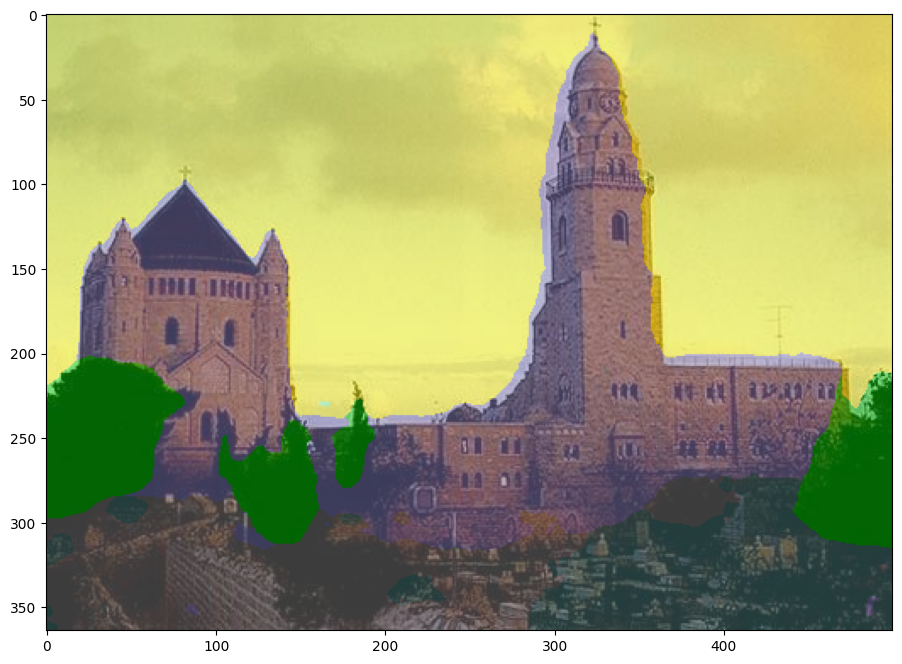

In [ ]:
# Create zeros matrix with (height, width, 3)
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8)

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color

# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.show()

### **5.2. Compare to the Ground Truth**

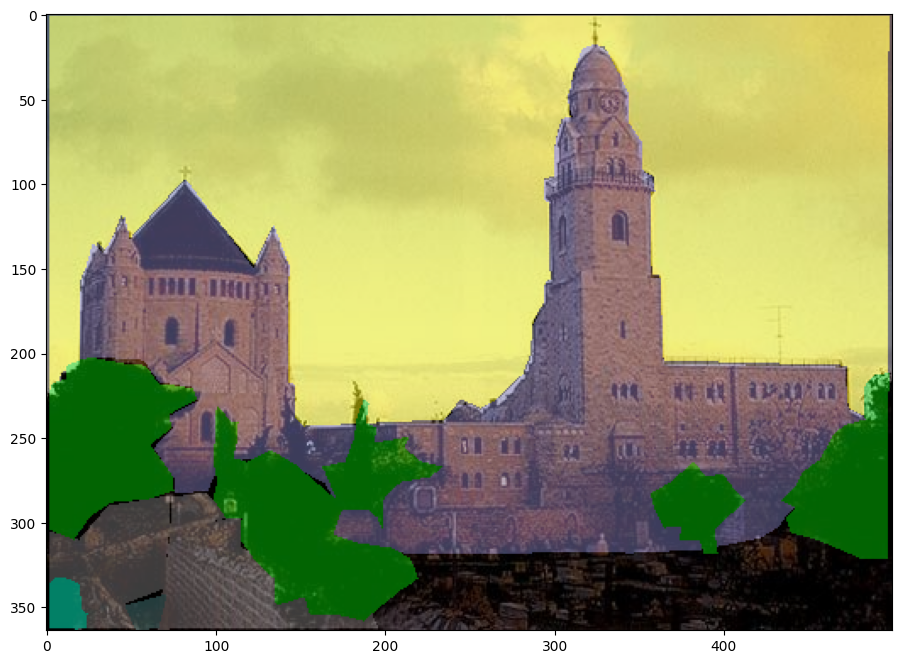

In [ ]:
ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color

# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.show()

In [ ]:
##################### END OF NOTEBOOK ######################